In [2]:
%matplotlib inline
import os
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

# --- Set environment variables for ROOT ---
conda_prefix = os.environ.get("CONDA_PREFIX")
os.environ["ROOT_INCLUDE_PATH"] = os.path.join(conda_prefix, "include")
os.environ["LD_LIBRARY_PATH"] = os.path.join(conda_prefix, "lib") + ":" + os.environ.get("LD_LIBRARY_PATH", "")

# --- Silence ROOT info/warning spam ---
ROOT.gErrorIgnoreLevel = ROOT.kFatal  # only show fatal errors
ROOT.gROOT.SetBatch(True)             # suppress GUI popups
ROOT.EnableImplicitMT()               # enable multithreading

# --- ATLAS style ---
atlas_style_dir = "/home/kalelc/research/atlasstyle/"
ROOT.gROOT.LoadMacro(os.path.join(atlas_style_dir, "AtlasStyle.C"))
ROOT.gROOT.LoadMacro(os.path.join(atlas_style_dir, "AtlasUtils.C"))
ROOT.gROOT.LoadMacro(os.path.join(atlas_style_dir, "AtlasLabels.C"))
ROOT.SetAtlasStyle()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(os.path.join(delphes_dir, "libDelphes.so"))
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully ✅")

# --- Input ROOT file ---
fdir = os.path.join(delphes_dir, "displacedPhoton_data/calo_met_prompt_half_dark_events.root")


Applying ATLAS style settings...

libDelphes.so loaded successfully ✅


Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeReader.h
   requested to autoload type ExRootTreeReader
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeWriter.h
   requested to autoload type ExRootTreeWriter
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeBranch.h
   requested to autoload type ExRootTreeBranch
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootResult.h
   requested to autoload type ExRootResult
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootClassifier.h
   requested to autoload type ExRootClassifier
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootFilter.h
   requested to autoload type ExRootFil

In [3]:
# Input ROOT file
df = ROOT.RDataFrame("Delphes", fdir)

PHI_FINAL_STATUS = 62
FINAL_STATUS = 1
DPHOTON_PID = 4900022
PHOTON_PID = 22
PHI_PID = 54

EVENT_FILTER = 5000

In [4]:
# --- Convert truth particles to pandas ---
particle_df = ROOT.RDataFrame("Delphes", fdir)
particle_dict = particle_df.AsNumpy([
    "Event.Number",
    "Particle.PT",
    "Particle.Phi",
    "Particle.Eta",
    "Particle.T",
    "Particle.PID",
    "Particle.fUniqueID",
    "Particle.D1",
    "Particle.D2",
    "Particle.Status",
])

# Flatten event numbers (scalars, not 1-element arrays)
event_numbers = [arr[0] for arr in particle_dict["Event.Number"]]
# df = df.Filter("Event.Number < {}".format(EVENT_FILTER), "Events below event filter")

# Add particle indices per event (needed for mother/daughter lookup)
particle_dict["Particle.Index"] = [
    np.arange(len(pt)) for pt in particle_dict["Particle.PT"]
]

# Build DataFrame
particle_df = pd.DataFrame({
    "event": event_numbers,
    "ParticleIndex": particle_dict["Particle.Index"],
    "PT": particle_dict["Particle.PT"],
    "Phi": particle_dict["Particle.Phi"],
    "Eta": particle_dict["Particle.Eta"],
    "T": particle_dict["Particle.T"],
    "PID": particle_dict["Particle.PID"],
    "UniqueID": particle_dict["Particle.fUniqueID"],  # keep for reference
    "D1": particle_dict["Particle.D1"],
    "D2": particle_dict["Particle.D2"],
    "Status": particle_dict["Particle.Status"],
})

# Event Filter
particle_df = particle_df[(particle_df["event"] < EVENT_FILTER)]

# Correct time units from s to ns
particle_df["T"] = particle_df["T"].apply(lambda t_arr: t_arr * 1e9)

# Explode so each particle gets its own row
particle_df = particle_df.explode([
    "ParticleIndex", "PT", "Phi", "Eta", "T", "PID", "UniqueID",
    "D1", "D2", "Status"
], ignore_index=True)

# Convert indices to integer
particle_df[["ParticleIndex", "D1", "D2"]] = particle_df[["ParticleIndex", "D1", "D2"]].astype(int)

particle_df = particle_df.sort_values(by="event").reset_index(drop=True)

particle_df.head(4)

,event,ParticleIndex,PT,Phi,Eta,T,PID,UniqueID,D1,D2,Status
0,0,25,0.165263,-0.413102,6.005406,0.0,-1,26,303,331,71
1,0,24,0.320058,-1.502473,10.219034,0.0,2101,25,181,209,71
2,0,23,0.0,0.0,999.900024,0.0,1,24,41,42,31
3,0,100,0.756196,-2.008071,1.604866,0.0,21,99,101,101,44


In [5]:
# Create the RDataFrame
df = ROOT.RDataFrame("Delphes", fdir)

# Filter out events that have no photons to prevent errors
df = df.Filter("Photon_size > 0", "Events with at least one photon")
# df = df.Filter("Event.Number < {}".format(EVENT_FILTER), "Events below event filter")

df = df.AsNumpy([
    "Event.Number",
    "Photon_size", "Photon.PT", "Photon.Eta", "Photon.Phi", "Photon.T",
    "Jet_size", "Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass",
    "MissingET.MET", "MissingET.Phi",
    "GenMissingET.MET", "GenMissingET.Eta", "GenMissingET.Phi"
    ]) # Add all relevant Branches

df = pd.DataFrame({
    "event": [arr[0] for arr in df["Event.Number"]],
    "photon_size": [arr for arr in df["Photon_size"]],
    "photon_pt": [arr for arr in df["Photon.PT"]],
    "photon_eta": [arr for arr in df["Photon.Eta"]],
    "photon_phi": [arr for arr in df["Photon.Phi"]],
    "photon_t": [arr for arr in df["Photon.T"]],
    "met": [arr[0] for arr in df["MissingET.MET"]],
    "met_phi": [arr[0] for arr in df["MissingET.Phi"]],
    "genmet": [arr[0] for arr in df["GenMissingET.MET"]],
    "genmet_eta": [arr[0] for arr in df["GenMissingET.Eta"]],
    "genmet_phi": [arr[0] for arr in df["GenMissingET.Phi"]],
})

# Event Filter
df = df[df["event"] < EVENT_FILTER]

# Correct time units from s to ns
df["photon_t"] = df["photon_t"].apply(lambda t_arr: t_arr * 1e9)

# Sort the dataframe by the 'event' column and set it as the index
df = df.sort_values(by="event")

df = df.explode([
    "photon_pt", "photon_eta", "photon_phi", "photon_t"
], ignore_index=True)

df.head(4)

,event,photon_size,photon_pt,photon_eta,photon_phi,photon_t,met,met_phi,genmet,genmet_eta,genmet_phi
0,0,1,38.24575,1.586421,-0.336175,9.796435,38.193195,-1.335756,39.143513,0.179296,-1.479393
1,1,1,57.159962,0.326268,-0.548867,4.046798,21.571005,-2.194716,23.687180,1.921988,-1.932783
2,2,1,46.879234,-0.249339,-2.934141,3.967296,90.675583,-0.418172,95.386909,0.988994,-0.467594
3,3,2,57.284534,0.321744,-0.541536,4.046798,82.190346,2.799991,78.944168,2.318977,2.877817


In [6]:
# --- Step 1: Filter phi candidates ---
phi_df = particle_df[
    (particle_df["PID"] == PHI_PID) &
    (particle_df["Status"] == PHI_FINAL_STATUS)
]

# --- Step 2: Collect all phi daughters in a fast, vectorized way ---
phi_daughters = (
    phi_df.melt(
        id_vars=["event"], 
        value_vars=["D1", "D2"], 
        value_name="phi_daughter_index"   # temporary name to avoid collision
    )[["event", "phi_daughter_index"]]
    .rename(columns={"phi_daughter_index": "ParticleIndex"})
)

# --- Step 3: Keep only particles that match any phi daughter ---
particle_df = particle_df.merge(
    phi_daughters,
    on=["event", "ParticleIndex"],
    how="inner",
    indicator=False
)

# --- Step 4: Apply your physics cuts ---
particle_df = particle_df[
    (particle_df["PT"] > 10.0) &
    (particle_df["Eta"].abs() <= 2.5)
]

In [7]:
# --- (Optional sanity check) ---
print(f"Remaining particles: {len(particle_df)}")
particle_df.head(4)

Remaining particles: 17870


,event,ParticleIndex,PT,Phi,Eta,T,PID,UniqueID,D1,D2,Status
1,0,908,45.886658,-2.942649,-0.260911,0.0,4900022,909,-1,-1,1
2,0,907,57.028271,-0.552128,0.33003,0.0,4900022,908,-1,-1,1
3,0,906,38.861732,-0.343372,1.589994,0.0,22,907,-1,-1,1
5,1,906,38.861732,-0.343372,1.589994,0.0,4900022,907,-1,-1,1


In [8]:
tp_filter = particle_df["PID"] == 22

# Dataframe containing only phi daughter truth photons that would pass reconstructed cuttoffs.
tpdf = pd.DataFrame()
tpdf["event"] = np.concat((particle_df[tp_filter]["event"], df["event"]))
tpdf["pt"] = np.concat((particle_df[tp_filter]["PT"], df["photon_pt"]))
tpdf["eta"] = np.concat((particle_df[tp_filter]["Eta"], df["photon_eta"]))
tpdf["phi"] = np.concat((particle_df[tp_filter]["Phi"], df["photon_phi"]))
tpdf["t"] = np.concat((particle_df[tp_filter]["T"], df["photon_t"]))
tpdf["truth"] = np.concat((np.ones(particle_df[tp_filter].shape[0], dtype=bool), np.zeros(df.shape[0], dtype=bool)))

tpdf = tpdf.sort_values(by="event").reset_index(drop=True)
tpdf["id"] = tpdf.index
print(tpdf.shape)
tpdf.head(4)

(15877, 7)


,event,pt,eta,phi,t,truth,id
0,0,38.24575,1.586421,-0.336175,9.796435,False,0
1,0,38.861732,1.589994,-0.343372,0.0,True,1
2,1,57.028271,0.33003,-0.552128,0.0,True,2
3,1,57.159962,0.326268,-0.548867,4.046798,False,3


In [9]:
def find_reco_match(truth_row, reco_df, delta_r_cut=0.1):
    """Search for a matching reconstructed photon for a given truth photon.

    Args:
        truth_row (pd.Series): The truth photon row to match.
        reco_df (pd.DataFrame): The DataFrame containing reconstructed photons.
        delta_r_cut (float, optional): The maximum delta R for a match. Defaults to 0.1.
    """
    reco_df = reco_df[reco_df["event"] == truth_row["event"]]
    if reco_df.empty:
        return None
    
    # Calculate delta pt for all reconstructed particles
    reco_df["delta_pt"] = np.abs(reco_df["pt"].astype(float) - float(truth_row["pt"]))

    # Calculate delta R for all reconstructed particles and apply cutoff
    reco_df["delta_r"] = np.sqrt(
        (reco_df["eta"].astype(float) - float(truth_row["eta"])) ** 2 + 
        (reco_df["phi"].astype(float) - float(truth_row["phi"])) ** 2
    )

    # Find the best matching truth particle
    best_match = reco_df[reco_df["delta_r"] < delta_r_cut].sort_values(
        by="delta_pt"
    )

    if not best_match.empty:
        return best_match.iloc[0]["id"]
    return None

def truth_pair(row, tpdf):
    """Find the matching truth photon for a given reconstructed photon.
    Must be run after find_reco_match to ensure matches established.

    Args:
        row (pd.Series): The reconstructed photon row to match.
        tpdf (pd.DataFrame): The DataFrame containing truth photons.
    """
    # Get the event ID for the reconstructed photon
    event_id = row["event"]
    photon_id = row["id"]

    # Find the truth photon with the same event ID
    truth_candidates = tpdf[(tpdf["event"] == event_id) & (tpdf["truth"] == 1)]

    if truth_candidates.empty:
        return None

    # Find the truth photon that matched to this reconstructed photon
    truth_candidates = truth_candidates[truth_candidates["match"] == photon_id]
    assert truth_candidates.shape[0] <= 1, f"Multiple truth matches found for reco photon {photon_id} in event {event_id}"
    if truth_candidates.shape[0] == 1:
        return truth_candidates.iloc[0]["id"]
    return None

In [10]:
tpdf["match"] = tpdf.apply(lambda row: find_reco_match(row, tpdf[tpdf["truth"] == 0]), axis=1)
tpdf["match"] = tpdf.apply(lambda row: truth_pair(row, tpdf) if row["truth"] == 0 else row["match"], axis=1)
tpdf["match"] = tpdf["match"].fillna(-999).astype(int) # Fill NaN values with -999 and convert to int
tpdf.head(10)

,event,pt,eta,phi,t,truth,id,match
0,0,38.24575,1.586421,-0.336175,9.796435,False,0,1
1,0,38.861732,1.589994,-0.343372,0.0,True,1,0
2,1,57.028271,0.33003,-0.552128,0.0,True,2,3
3,1,57.159962,0.326268,-0.548867,4.046798,False,3,2
4,2,45.886658,-0.260911,-2.942649,0.0,True,4,5
5,2,46.879234,-0.249339,-2.934141,3.967296,False,5,4
6,3,57.028271,0.33003,-0.552128,0.0,True,6,8
7,3,39.459129,1.583968,-0.348154,9.796435,False,7,9
8,3,57.284534,0.321744,-0.541536,4.046798,False,8,6
9,3,38.861732,1.589994,-0.343372,0.0,True,9,7


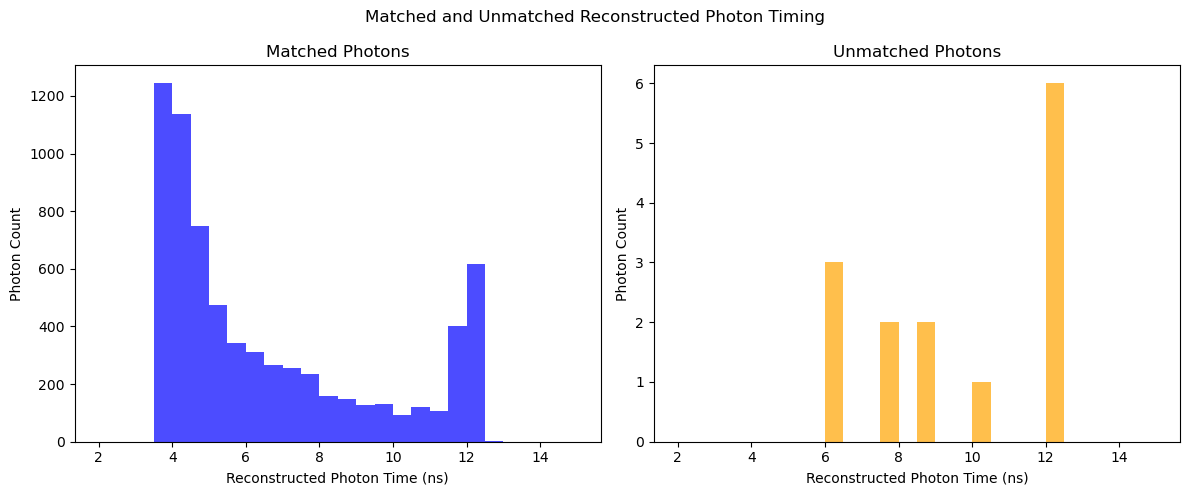

In [11]:
# Photon timing
reco_timing = tpdf[tpdf["truth"] == 0]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(reco_timing[reco_timing["match"] >= 0]["t"], bins=26, range=(2, 15), histtype='stepfilled', color='blue', alpha=0.7)
ax[0].set_xlabel("Reconstructed Photon Time (ns)")
ax[0].set_ylabel("Photon Count")
ax[0].set_title("Matched Photons")
ax[1].hist(reco_timing[reco_timing["match"] < 0]["t"], bins=26, range=(2, 15), histtype='stepfilled', color='orange', alpha=0.7)
ax[1].set_xlabel("Reconstructed Photon Time (ns)")
ax[1].set_ylabel("Photon Count")
ax[1].set_title("Unmatched Photons")
fig.suptitle("Matched and Unmatched Reconstructed Photon Timing")
plt.savefig("prompt_half_dark_plots/reco_photon_timing.png")
fig.tight_layout()
plt.show()

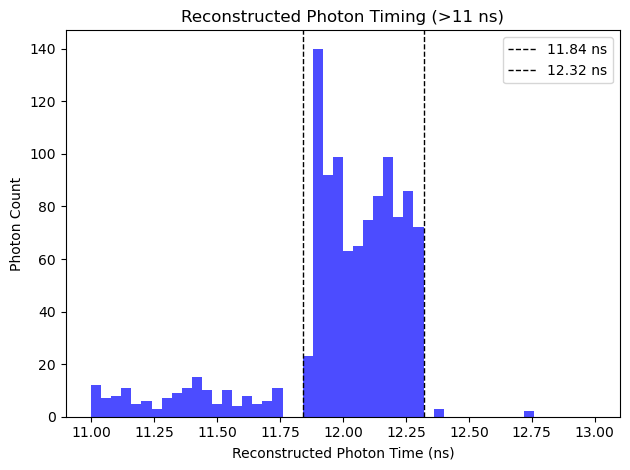

In [12]:
plt.hist(reco_timing['t'], bins=50, range=(11, 13), histtype='stepfilled', color='blue', alpha=0.7)
plt.axvline(x=11.84, color='k', linestyle='dashed', linewidth=1, label='11.84 ns')
plt.axvline(x=12.32, color='k', linestyle='dashed', linewidth=1, label='12.32 ns')
plt.xlabel("Reconstructed Photon Time (ns)")
plt.ylabel("Photon Count")
plt.title("Reconstructed Photon Timing (>11 ns)")
plt.legend()
plt.savefig("prompt_half_dark_plots/reco_photon_timing_zoomed.png")
plt.tight_layout()
plt.show()

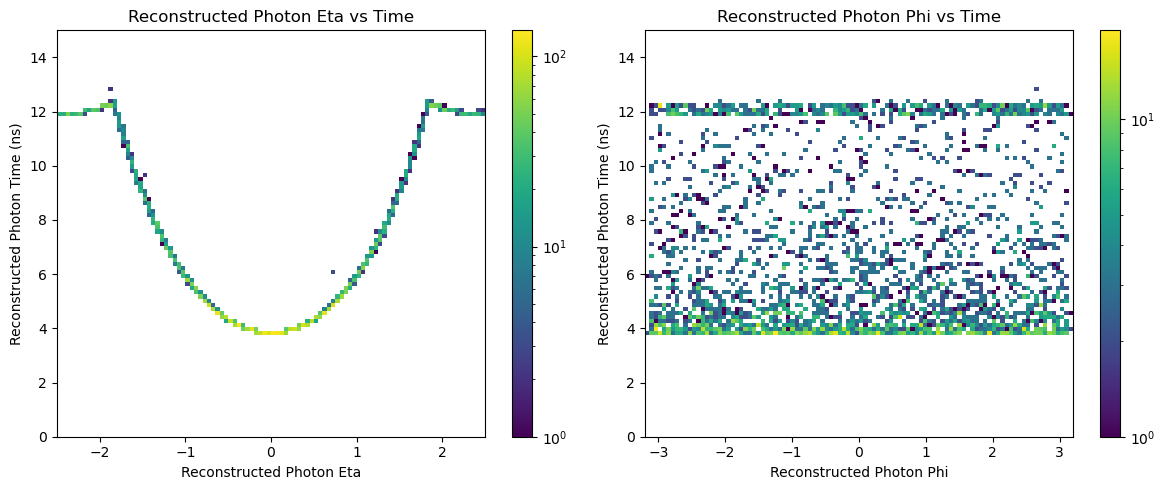

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
h1 = ax[0].hist2d(reco_timing["eta"], reco_timing["t"], bins=(100, 100), range=[[-2.5, 2.5], [0, 15]], cmap="viridis", norm=LogNorm())
ax[0].set_xlabel("Reconstructed Photon Eta")
ax[0].set_ylabel("Reconstructed Photon Time (ns)")
ax[0].set_title("Reconstructed Photon Eta vs Time")
fig.colorbar(h1[3], ax=ax[0])
h2 = ax[1].hist2d(reco_timing["phi"], reco_timing["t"], bins=(100, 100), range=[[-3.2, 3.2], [0, 15]], cmap="viridis", norm=LogNorm())
ax[1].set_xlabel("Reconstructed Photon Phi")
ax[1].set_ylabel("Reconstructed Photon Time (ns)")
ax[1].set_title("Reconstructed Photon Phi vs Time")
fig.colorbar(h2[3], ax=ax[1])
plt.tight_layout()
plt.savefig("prompt_half_dark_plots/reco_photon_eta_phi_vs_time.png")

In [70]:
# Convert eta to numeric (float) to avoid object-dtype dispatch issues, then compute theta
eta_vals = pd.to_numeric(reco_timing["eta"], errors="coerce").astype(float)
theta = 2 * np.arctan(np.exp(-eta_vals))
r = pd.to_numeric(reco_timing["t"] * .299792458, errors="coerce").astype(float)
det_r = r * np.sin(theta)
det_z = r * np.cos(theta)
det_z.min(), det_z.max(), det_r.min(), det_r.max()

(np.float64(-7.205669906758532),
 np.float64(4.223307073504519),
 np.float64(0.5818024939549723),
 np.float64(5.402724127061054))

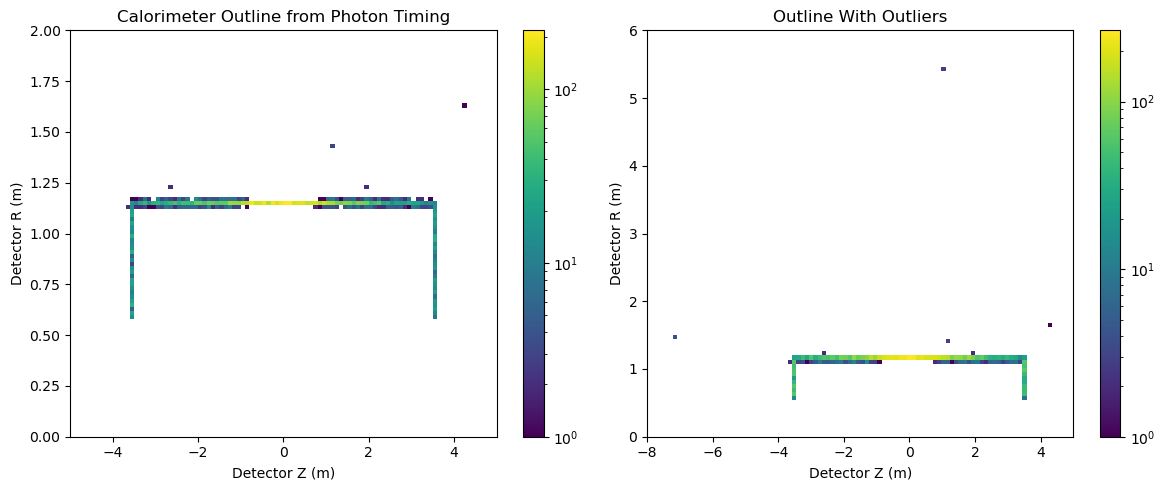

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
h1 = ax[0].hist2d(det_z, det_r, bins=(100, 100), range=[[-5, 5], [0, 2]], cmap="viridis", norm=LogNorm())
ax[0].set_xlabel("Detector Z (m)")
ax[0].set_ylabel("Detector R (m)")
ax[0].set_title("Calorimeter Outline from Photon Timing")
fig.colorbar(h1[3], ax=ax[0])
h2 = ax[1].hist2d(det_z, det_r, bins=(100, 100), range=[[-8, 5], [0, 6]], cmap="viridis", norm=LogNorm())
ax[1].set_xlabel("Detector Z (m)")
ax[1].set_ylabel("Detector R (m)")
ax[1].set_title("Outline With Outliers")
fig.colorbar(h2[3], ax=ax[1])
plt.tight_layout()
plt.savefig("prompt_half_dark_plots/calo_outline.png")

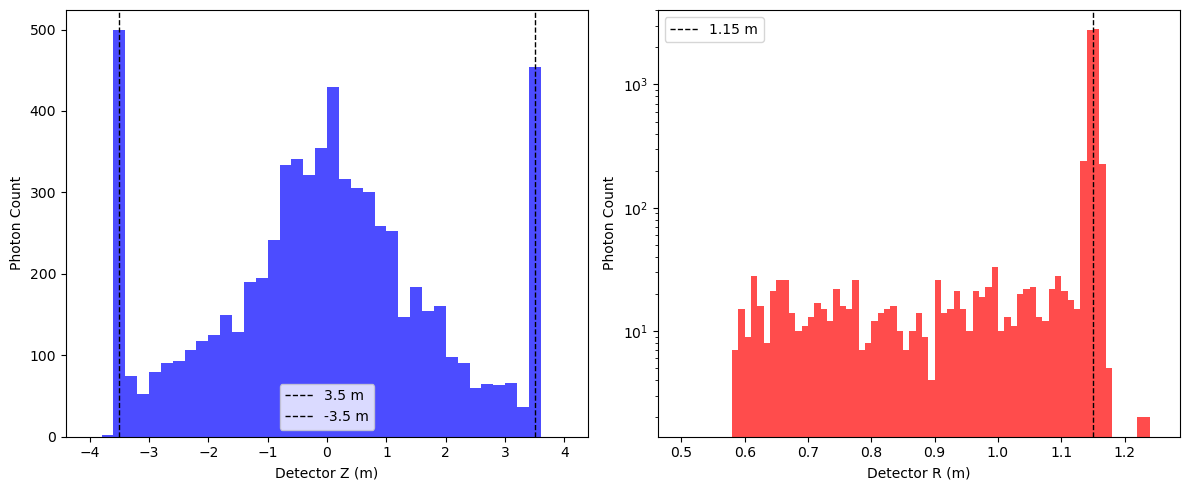

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(det_z, bins=40, range=(-4, 4), histtype='stepfilled', color='blue', alpha=0.7)
ax[0].set_xlabel("Detector Z (m)")
ax[0].set_ylabel("Photon Count")
ax[0].axvline(x=3.5, color='k', linestyle='dashed', linewidth=1, label='3.5 m')
ax[0].axvline(x=-3.5, color='k', linestyle='dashed', linewidth=1, label='-3.5 m')
ax[0].legend()
ax[1].hist(det_r, bins=75, range=(0.5, 1.25), histtype='stepfilled', color='red', alpha=0.7)
ax[1].set_xlabel("Detector R (m)")
ax[1].set_ylabel("Photon Count")
ax[1].axvline(x=1.15, color='k', linestyle='dashed', linewidth=1, label='1.15 m')
ax[1].legend()
ax[1].set_yscale('log')
plt.tight_layout()
plt.savefig("prompt_half_dark_plots/calo_zr_dist.png")

The fraction of unmatched photons is greater than expceted. Unmatched photons from photon efficiency should be between 5% and 15% based on different eta range. 

Additionally, expected behaivor would suggest that all unmatched photons are truth photons with their reconstructed pair lost to photon efficeincy, but there are unmatched reconstructed photons that have properties not close to unmatched truth photons in the same event.

To look into whether any combination of pt, eta, phi are leading to unmatched photons, see plots below.

In [16]:
matched_photons = tpdf[tpdf["match"] >= 0]
unmatched_photons = tpdf[tpdf["match"] < 0]

unmatched_fraction = unmatched_photons[unmatched_photons["truth"] == 1]["id"].nunique() / tpdf[tpdf["truth"] == 1]["id"].nunique()
print(f"Fraction of unmatched photons: {unmatched_fraction:.2%}")
print("Unmatched photons by truth/reco:")
print(unmatched_photons["truth"].value_counts()) # Unmatched reco photons are caused because the only truth photons I allow are phi daughters
tpdf[tpdf["event"].isin(unmatched_photons[unmatched_photons["truth"] == 0]["event"])].head(10)

Fraction of unmatched photons: 22.55%
Unmatched photons by truth/reco:
truth
True     2015
False      22
Name: count, dtype: int64


,event,pt,eta,phi,t,truth,id,match
462,148,112.181793,-0.905969,-0.281987,5.576652,False,462,464
463,148,40.859478,-1.958689,0.464102,12.185441,False,463,-999
464,148,113.618347,-0.919875,-0.284745,0.0,True,464,462
465,148,78.360527,-0.400037,-2.472612,0.0,True,465,-999
5232,1627,125.442291,-2.249445,1.007298,0.0,True,5232,5235
5233,1627,44.081181,-0.005414,2.199914,0.0,True,5233,-999
5234,1627,39.590294,2.451799,-2.294294,12.039655,False,5234,-999
5235,1627,126.618172,-2.24683,1.010361,11.971448,False,5235,5232
5236,1628,40.383678,2.440567,-2.287281,12.039655,False,5236,-999
5237,1628,125.943878,-2.24912,1.007961,11.971448,False,5237,5240


/tmp/ipykernel_14277/1991622709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_truth_photons["matched"] = matched_truth_photons.apply(lambda row: 1 if row["match"] >= 0 else 0, axis=1)
/tmp/ipykernel_14277/1991622709.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=_df, x="matched", y="count", ax=ax[i], palette=color_palette)
/tmp/ipykernel_14277/1991622709.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=_df, x="matche

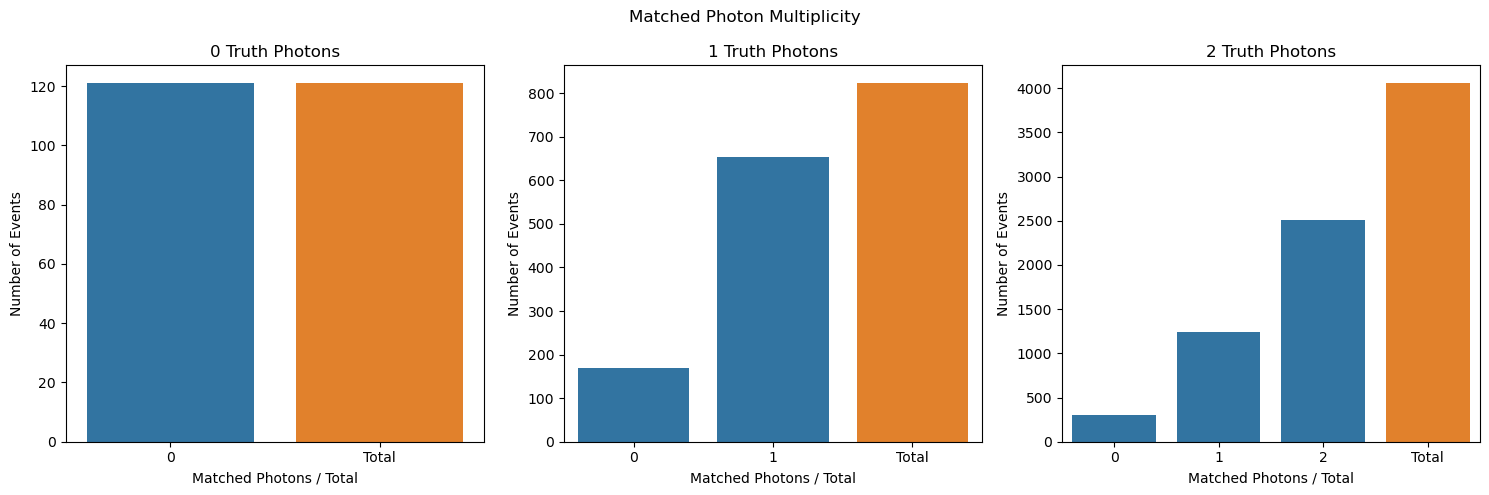

In [17]:
photon_count = pd.DataFrame({"event": np.arange(tpdf.event.max() + 1)})

# Add number of truth photons that pass cutoffs
photon_count = photon_count.merge(right = tpdf[tpdf["truth"]].groupby("event").count()[["truth"]], on="event", how="left") # Count the number of unique truth photons per event

# Count the number of matched photons per event
matched_truth_photons = tpdf[tpdf["truth"]]
matched_truth_photons["matched"] = matched_truth_photons.apply(lambda row: 1 if row["match"] >= 0 else 0, axis=1)
matched_truth_photons = matched_truth_photons.groupby("event").sum()[["matched"]].reset_index()
photon_count = photon_count.merge(right = matched_truth_photons, on="event", how="left")
photon_count = photon_count.fillna(0).astype(int)

truth_counts = photon_count.groupby("truth").count()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
# Plot the Barplots
    _df = photon_count[photon_count["truth"] == i]
    _df = _df.groupby("matched").count()
    
    # Capture the current bar categories (the 'matched' values)
    categories = _df.index.tolist()
    
    _df.loc["Total"] = truth_counts.loc[i]
    _df = _df[["event"]]

    # Prepare for custom coloring by resetting the index
    _df = _df.reset_index().rename(columns={'index': 'category', 'event': 'count'})

    # Define colors
    standard_color = '#1f77b4'  # Blue
    total_color = '#ff7f0e'       # Orange
    
    # Create the palette: standard_color for each original category, then total_color for 'Total'
    color_palette = [standard_color] * len(categories) + [total_color]

    # Use 'category' for x-axis, 'count' for y-axis, and apply the custom palette
    sns.barplot(data=_df, x="matched", y="count", ax=ax[i], palette=color_palette)
    
    # Update x-label to reflect the new category name
    ax[i].set_xlabel("Matched Photons / Total")
    ax[i].set_ylabel("Number of Events")
    ax[i].set_title(f"{i} Truth Photons")
fig.suptitle("Matched Photon Multiplicity")

# Save the plot
plt.tight_layout()
plt.savefig("truth_plots/photon_multiplicity.png")
plt.show()


In [14]:
# Group by event and calculate the counts of truth=True and truth=False
truth_counts = tpdf.groupby("event")["truth"].value_counts().unstack(fill_value=0)

# Filter events with exactly 2 truth=True and 0 truth=False
filtered_events = truth_counts[(truth_counts[True] == 2) & (truth_counts[False] == 0)]

# Extract the event IDs
filtered_event_ids = filtered_events.index.tolist()

# Filter the original tpdf for these events
tpdf[tpdf["event"].isin(filtered_event_ids)].head()

,event,pt,eta,phi,t,truth,id,match
22,7,55.444016,-0.305104,2.906842,0.0,True,22,-999
23,7,52.181995,-0.240868,-0.787658,0.0,True,23,-999
160,52,47.574459,-0.429519,-2.616707,0.0,True,160,-999
161,52,73.246979,0.871916,0.98803,0.0,True,161,-999
216,68,25.39817,-0.715526,2.007658,0.0,True,216,-999


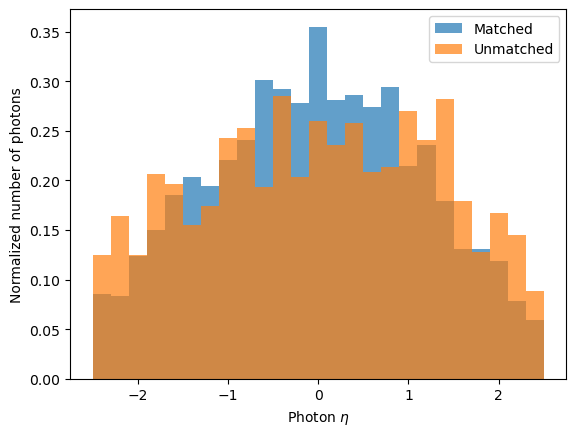

In [15]:
plt.hist(matched_photons["eta"], bins=25, range=(-2.5, 2.5), alpha=0.7, label="Matched", density=True)
plt.hist(unmatched_photons["eta"], bins=25, range=(-2.5, 2.5), alpha=0.7, label="Unmatched", density=True)
plt.xlabel(r"Photon $\eta$")
plt.ylabel("Normalized number of photons")
plt.legend()

plt.savefig("truth_plots/unmatched_eta.png")

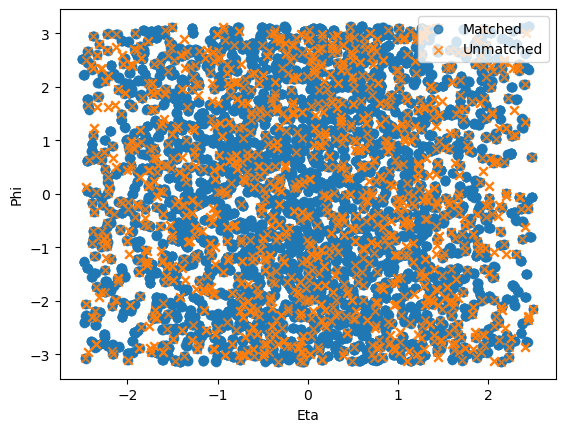

In [16]:
plt.scatter(matched_photons["eta"], matched_photons["phi"], marker="o", alpha=0.8, label="Matched")
plt.scatter(unmatched_photons["eta"], unmatched_photons["phi"], marker="x", alpha=0.8, label="Unmatched")
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.legend()

plt.savefig("truth_plots/unmatched_eta_phi.png")

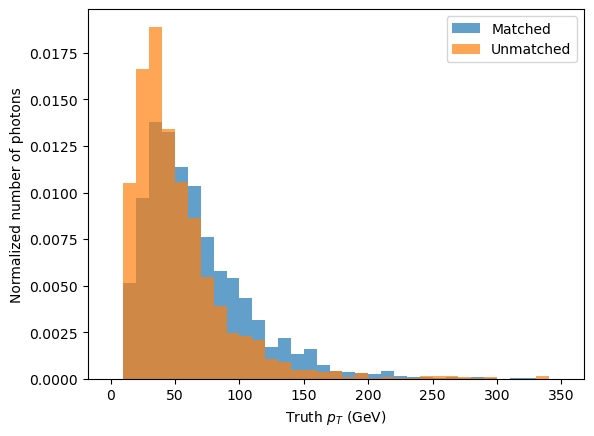

In [17]:
plt.hist(matched_photons["pt"], bins=35, range=(0,350), alpha=0.7, label="Matched", density=True)
plt.hist(unmatched_photons["pt"], bins=35, range=(0,350), alpha=0.7, label="Unmatched", density=True)
plt.xlabel(r"Truth $p_{T}$ (GeV)")
plt.ylabel("Normalized number of photons")
plt.legend()

plt.savefig("truth_plots/unmatched_pt.png")

After applying selection cuts ($\eta <= 2.5, p_{T} > 10.0 GeV$) to the truth photons, we se that ~22% of photons are missed. The Delphes ATLAS card defined photon effiency as 95% for $\eta < 1.5$ and 85% for $1.5 < \eta < 2.5$. Because of this we would expect to see an unmatched photon rate of between 5-15%. (a value we could calcualte more precisely to compare to if observed value was not already outside of this range) However, the observed unmatched rate is 22.55%. These plots show that there is no clear $\eta, \phi$ distribution correlation to the unmatched photons. The histogram displaying the $p_{T}$ of matched vs unmatched photons suggests that lower $p_{T}$ photons are more likely to not be reconstructed. This makes physical sense that photons with less energy are less likely to be reconstructed by the detector.